# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [2]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [3]:
train_dir = '/content/drive/My Drive/Dataset_200/dataset/train/'
test_dir = '/content/drive/My Drive/Dataset_200/dataset/test/'
validation_dir = '/content/drive/My Drive/Dataset_200/dataset/validation/'

In [4]:
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)
X_val, y_val, _ = load_data(validation_dir, IMG_SIZE)

100%|██████████| 2/2 [00:30<00:00, 15.49s/it]


1536 images loaded from /content/drive/My Drive/Dataset_200/dataset/train/ directory.


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


480 images loaded from /content/drive/My Drive/Dataset_200/dataset/test/ directory.


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]

384 images loaded from /content/drive/My Drive/Dataset_200/dataset/validation/ directory.


In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [6]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [8]:
input_shape = (224,224, 3)
batch_size = 32

In [9]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


# VGG16

In [11]:
pretrained_vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[224, 224, 3])
pretrained_vgg16_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [12]:
def print_layer_trainable():
    for layer in pretrained_vgg16_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# print_layer_trainable()

print('Num layers, ', len(pretrained_vgg16_model.layers))


Num layers,  19


In [13]:
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU

model_vgg = tf.keras.Sequential([
                             pretrained_vgg16_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                             ])

model_vgg.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    # min_delta=0.000001,
    patience=6,
    min_lr=1e-6,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )

filename = '/content/drive/MyDrive/models/Defense/vgg16.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

history = model_vgg.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.6562
Epoch 1: val_accuracy improved from -inf to 0.70312, saving model to /content/drive/MyDrive/models/Defense/vgg16.h5
48/48 [==============================] - 33s 367ms/step - loss: 0.6325 - accuracy: 0.6562 - val_loss: 0.4941 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8105
Epoch 2: val_accuracy improved from 0.70312 to 0.86198, saving model to /content/drive/MyDrive/models/Defense/vgg16.h5
48/48 [==============================] - 18s 382ms/step - loss: 0.4077 - accuracy: 0.8105 - val_loss: 0.3434 - val_accuracy: 0.8620 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8796
Epoch 3: val_accuracy improved from 0.86198 to 0.91667, saving model to /content/drive/MyDrive/models/Defense/vgg16.h5
48/48 [==============================] - 18s 377ms/step - loss: 0.

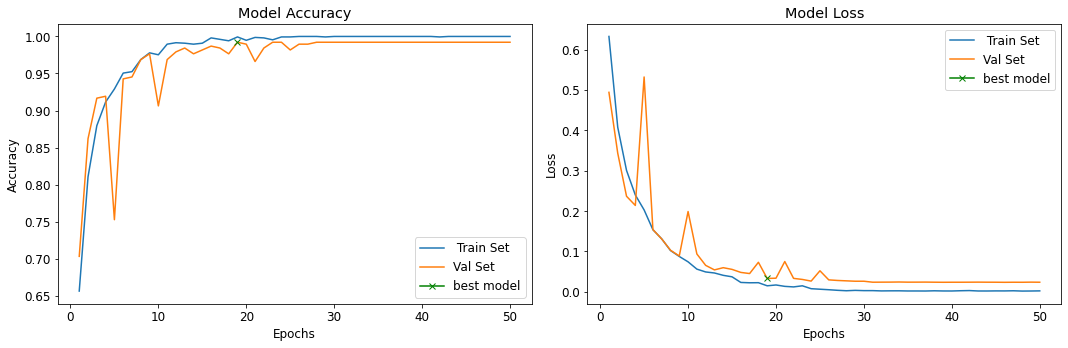

In [22]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.plot(19, 0.99219, marker="x", color="g", label="best model")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')
# epoch: 9 loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0241 - val_accuracy: 0.9948
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.plot(19, 0.0333, marker="x", color="g", label="best model")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import load_model
saved_model = load_model('/content/drive/MyDrive/models/Defense/vgg16.h5', compile = False)
# saved_model = load_model('./vgg16.h5', compile = False)

saved_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
# validation set
predictions = saved_model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]
# predictions = [1 if x>0.4 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 1.0000, Val: 0.9974
Validation Accuracy = 0.9115
Precision: 0.907216
Recall: 0.916667
F1 score: 0.911917
Cohens kappa: 0.822917
ROC AUC: 0.911458
[[174  18]
 [ 16 176]]
True positive: 176 , True negative: 174 , False positive: 18 , False negative: 16


Train: 0.9167, Test: 0.9021
Test Accuracy = 0.9021
Precision: 0.890688
Recall: 0.916667
F1 score: 0.903491
Cohens kappa: 0.804167
ROC AUC: 0.902083
[[213  27]
 [ 20 220]]
True positive: 220 , True negative: 213 , False positive: 27 , False negative: 20
Sensitivity: 0.9167
Specificity: 0.8875


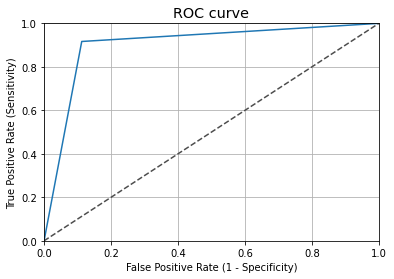

In [18]:
# test set (best)
predictions = saved_model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Train: 0.9160, Test: 0.8979
Test Accuracy = 0.8979
Precision: 0.902954
Recall: 0.891667
F1 score: 0.897275
Cohens kappa: 0.795833
ROC AUC: 0.897917
[[217  23]
 [ 26 214]]
True positive: 214 , True negative: 217 , False positive: 23 , False negative: 26
Sensitivity: 0.8917
Specificity: 0.9042


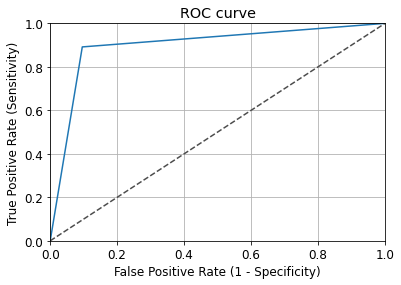

In [19]:
# test set (full epoch)
predictions = model_vgg.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model_vgg.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_vgg.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)